# Transition State Search (NEBs)

FAIR chemistry models can be used to enumerate and study reaction pathways via transition state search tools built into ASE or in packages like Sella via the ASE interface.

The first section of this tutorial walks through how to use the CatTsunami tools to automatically enumerate a number of hypothetical initial/final configurations for various types of reactions on a heterogeneous catalyst surface. If you already have a NEB you're looking to optimize, you can jump straight to the last section (Run NEBs)!

Since the NEB calculations here can be a bit time consuming, we'll use a small number of steps during the documentation testing, and otherwise use a reasonable guess.

In [1]:
import os

# Use a small number of steps here to keep the docs fast during CI, but otherwise do quite reasonable settings.
fast_docs = os.environ.get("FAST_DOCS", "false").lower() == "true"
if fast_docs:
    optimization_steps = 20
else:
    optimization_steps = 300

````{admonition} Need to install fairchem-core or get UMA access or getting permissions/401 errors?
:class: dropdown


1. Install the necessary packages using pip, uv etc
```{code-cell} ipython3
:tags: [skip-execution]

! pip install fairchem-core fairchem-data-oc fairchem-applications-cattsunami
```

2. Get access to any necessary huggingface gated models
    * Get and login to your Huggingface account
    * Request access to https://huggingface.co/facebook/UMA
    * Create a Huggingface token at https://huggingface.co/settings/tokens/ with the permission "Permissions: Read access to contents of all public gated repos you can access"
    * Add the token as an environment variable using `huggingface-cli login` or by setting the HF_TOKEN environment variable.

```{code-cell} ipython3
:tags: [skip-execution]

# Login using the huggingface-cli utility
! huggingface-cli login

# alternatively,
import os
os.environ['HF_TOKEN'] = 'MY_TOKEN'
```

````

## Do enumerations in an AdsorbML style

In [2]:
from __future__ import annotations

import matplotlib.pyplot as plt
from ase.io import read
from ase.mep import DyNEB
from ase.optimize import BFGS
from fairchem.applications.cattsunami.core import Reaction
from fairchem.applications.cattsunami.core.autoframe import AutoFrameDissociation
from fairchem.applications.cattsunami.databases import DISSOCIATION_REACTION_DB_PATH
from fairchem.core import FAIRChemCalculator, pretrained_mlip
from fairchem.data.oc.core import Adsorbate, AdsorbateSlabConfig, Bulk, Slab
from fairchem.data.oc.databases.pkls import ADSORBATE_PKL_PATH, BULK_PKL_PATH
from x3dase.x3d import X3D

# Instantiate the reaction class for the reaction of interest
reaction = Reaction(
    reaction_str_from_db="*CH -> *C + *H",
    reaction_db_path=DISSOCIATION_REACTION_DB_PATH,
    adsorbate_db_path=ADSORBATE_PKL_PATH,
)

In [3]:
# Instantiate our adsorbate class for the reactant and product
reactant = Adsorbate(
    adsorbate_id_from_db=reaction.reactant1_idx, adsorbate_db_path=ADSORBATE_PKL_PATH
)
product1 = Adsorbate(
    adsorbate_id_from_db=reaction.product1_idx, adsorbate_db_path=ADSORBATE_PKL_PATH
)
product2 = Adsorbate(
    adsorbate_id_from_db=reaction.product2_idx, adsorbate_db_path=ADSORBATE_PKL_PATH
)

In [4]:
# Grab the bulk and cut the slab we are interested in
bulk = Bulk(bulk_src_id_from_db="mp-33", bulk_db_path=BULK_PKL_PATH)
slab = Slab.from_bulk_get_specific_millers(bulk=bulk, specific_millers=(0, 0, 1))

In [5]:
# Perform site enumeration
# For AdsorbML num_sites = 100, but we use 5 here for brevity. This should be increased for practical use.
reactant_configs = AdsorbateSlabConfig(
    slab=slab[0],
    adsorbate=reactant,
    mode="random_site_heuristic_placement",
    num_sites=10,
).atoms_list
product1_configs = AdsorbateSlabConfig(
    slab=slab[0],
    adsorbate=product1,
    mode="random_site_heuristic_placement",
    num_sites=10,
).atoms_list
product2_configs = AdsorbateSlabConfig(
    slab=slab[0],
    adsorbate=product2,
    mode="random_site_heuristic_placement",
    num_sites=10,
).atoms_list

In [6]:
# Instantiate the calculator
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1")
calc = FAIRChemCalculator(predictor, task_name="oc20")

In [7]:
# Relax the reactant systems
reactant_energies = []
for config in reactant_configs:
    config.calc = calc
    config.pbc = True
    opt = BFGS(config)
    opt.run(fmax=0.05, steps=optimization_steps)
    reactant_energies.append(config.get_potential_energy())

      Step     Time          Energy          fmax
BFGS:    0 20:18:38     -300.883319        3.963400


BFGS:    1 20:18:38     -301.304394        3.494052


BFGS:    2 20:18:38     -302.579612        3.652916


BFGS:    3 20:18:38     -302.519813        7.093208


BFGS:    4 20:18:38     -302.912195        2.883902


BFGS:    5 20:18:38     -303.082170        1.282952


BFGS:    6 20:18:38     -303.124751        1.310806


BFGS:    7 20:18:38     -303.138931        0.580317


BFGS:    8 20:18:38     -303.150860        0.630291


BFGS:    9 20:18:38     -303.164673        0.795471


BFGS:   10 20:18:38     -303.183999        0.659266


BFGS:   11 20:18:38     -303.192171        0.348396


BFGS:   12 20:18:39     -303.196324        0.234615


BFGS:   13 20:18:39     -303.202008        0.554455


BFGS:   14 20:18:39     -303.210712        0.814456


BFGS:   15 20:18:39     -303.223346        0.859762


BFGS:   16 20:18:39     -303.233988        0.609923


BFGS:   17 20:18:39     -303.241691        0.401996


BFGS:   18 20:18:39     -303.256696        0.900497


BFGS:   19 20:18:39     -303.293570        2.173602


BFGS:   20 20:18:39     -303.322157        3.782891


BFGS:   21 20:18:39     -303.346862        4.218533


BFGS:   22 20:18:39     -303.362905        4.543367


BFGS:   23 20:18:40     -303.403428        5.051005


BFGS:   24 20:18:40     -303.469962        4.927781


BFGS:   25 20:18:40     -303.454967        3.200422


BFGS:   26 20:18:40     -303.531071        4.087498


BFGS:   27 20:18:40     -303.540648        4.413076


BFGS:   28 20:18:40     -303.669852        3.684601


BFGS:   29 20:18:40     -303.757417        2.334171


BFGS:   30 20:18:40     -303.817555        1.935470


BFGS:   31 20:18:40     -303.885299        1.706000


BFGS:   32 20:18:41     -303.906093        1.689853


BFGS:   33 20:18:41     -303.972107        1.894549


BFGS:   34 20:18:41     -304.011697        2.026897


BFGS:   35 20:18:41     -304.052886        2.056032


BFGS:   36 20:18:41     -304.083389        1.834992


BFGS:   37 20:18:41     -304.116041        1.577863


BFGS:   38 20:18:41     -304.145799        1.190221


BFGS:   39 20:18:41     -304.166352        1.034717


BFGS:   40 20:18:41     -304.181404        0.989630


BFGS:   41 20:18:41     -304.196537        1.011492


BFGS:   42 20:18:41     -304.215826        1.000320


BFGS:   43 20:18:41     -304.233681        0.930714


BFGS:   44 20:18:42     -304.247167        0.845031


BFGS:   45 20:18:42     -304.260114        0.766305


BFGS:   46 20:18:42     -304.275714        0.660434


BFGS:   47 20:18:42     -304.288389        0.506913


BFGS:   48 20:18:42     -304.297955        0.342637


BFGS:   49 20:18:42     -304.304686        0.274699


BFGS:   50 20:18:42     -304.310871        0.291512


BFGS:   51 20:18:42     -304.318905        0.269721


BFGS:   52 20:18:42     -304.329085        0.213875


BFGS:   53 20:18:42     -304.337403        0.165863


BFGS:   54 20:18:42     -304.343426        0.174369


BFGS:   55 20:18:42     -304.347550        0.122457


BFGS:   56 20:18:43     -304.349171        0.111368


BFGS:   57 20:18:43     -304.351148        0.092478


BFGS:   58 20:18:43     -304.353542        0.067797


BFGS:   59 20:18:43     -304.355249        0.052966


BFGS:   60 20:18:43     -304.355879        0.057315


BFGS:   61 20:18:43     -304.356084        0.062843


BFGS:   62 20:18:43     -304.356234        0.065217


BFGS:   63 20:18:43     -304.356461        0.064887


BFGS:   64 20:18:43     -304.356721        0.059501


BFGS:   65 20:18:43     -304.356917        0.051204


BFGS:   66 20:18:43     -304.357003        0.043680


      Step     Time          Energy          fmax
BFGS:    0 20:18:43     -301.343546        4.040383


BFGS:    1 20:18:44     -301.727695        3.061484


BFGS:    2 20:18:44     -302.773127        3.561792


BFGS:    3 20:18:44     -302.894677        4.265649


BFGS:    4 20:18:44     -303.189705        2.354285


BFGS:    5 20:18:44     -303.329693        3.307380


BFGS:    6 20:18:44     -303.415897        1.505734


BFGS:    7 20:18:44     -303.534271        1.159583


BFGS:    8 20:18:44     -303.839933        2.014661


BFGS:    9 20:18:44     -303.837534        3.144834


BFGS:   10 20:18:44     -303.962189        1.701961


BFGS:   11 20:18:44     -304.023239        0.987176


BFGS:   12 20:18:45     -304.090516        1.268067


BFGS:   13 20:18:45     -304.110109        0.801571


BFGS:   14 20:18:45     -304.137246        0.584296


BFGS:   15 20:18:45     -304.149189        0.422407


BFGS:   16 20:18:45     -304.155415        0.198426


BFGS:   17 20:18:45     -304.157861        0.146680


BFGS:   18 20:18:45     -304.161586        0.167551


BFGS:   19 20:18:45     -304.164221        0.167717


BFGS:   20 20:18:45     -304.166161        0.137922


BFGS:   21 20:18:45     -304.167291        0.091367


BFGS:   22 20:18:45     -304.168442        0.093944


BFGS:   23 20:18:45     -304.169965        0.131991


BFGS:   24 20:18:46     -304.171349        0.118732


BFGS:   25 20:18:46     -304.172045        0.064993


BFGS:   26 20:18:46     -304.172340        0.053614


BFGS:   27 20:18:46     -304.172652        0.076337


BFGS:   28 20:18:46     -304.173193        0.107693


BFGS:   29 20:18:46     -304.173827        0.100898


BFGS:   30 20:18:46     -304.174309        0.061881


BFGS:   31 20:18:46     -304.174600        0.061902


BFGS:   32 20:18:46     -304.174918        0.077726


BFGS:   33 20:18:46     -304.175621        0.151073


BFGS:   34 20:18:46     -304.177185        0.252802


BFGS:   35 20:18:46     -304.179927        0.344351


BFGS:   36 20:18:47     -304.183471        0.322456


BFGS:   37 20:18:47     -304.189820        0.251345


BFGS:   38 20:18:47     -304.200597        0.490667


BFGS:   39 20:18:47     -304.211747        0.773494


BFGS:   40 20:18:47     -304.227924        1.244161


BFGS:   41 20:18:47     -304.253996        1.021029


BFGS:   42 20:18:47     -304.303690        0.294006


BFGS:   43 20:18:47     -304.291578        0.987233


BFGS:   44 20:18:47     -304.331043        0.276531


BFGS:   45 20:18:47     -304.335830        0.213903


BFGS:   46 20:18:47     -304.341496        0.156641


BFGS:   47 20:18:48     -304.346425        0.132218


BFGS:   48 20:18:48     -304.351139        0.100712


BFGS:   49 20:18:48     -304.354007        0.073706


BFGS:   50 20:18:48     -304.355031        0.080790


BFGS:   51 20:18:48     -304.355504        0.070683


BFGS:   52 20:18:48     -304.355895        0.052541


BFGS:   53 20:18:48     -304.356314        0.042876


      Step     Time          Energy          fmax
BFGS:    0 20:18:48     -301.829839        4.142389


BFGS:    1 20:18:48     -302.219170        3.305661


BFGS:    2 20:18:48     -303.169428        3.219499


BFGS:    3 20:18:48     -303.326895        3.049524


BFGS:    4 20:18:48     -303.598520        1.971730


BFGS:    5 20:18:49     -303.770946        2.935473


BFGS:    6 20:18:49     -303.863408        1.654217


BFGS:    7 20:18:49     -303.999388        0.768007


BFGS:    8 20:18:49     -304.038581        0.887513


BFGS:    9 20:18:49     -304.096717        0.879521


BFGS:   10 20:18:49     -304.165091        0.937040


BFGS:   11 20:18:49     -304.206253        0.595199


BFGS:   12 20:18:49     -304.228045        0.436315


BFGS:   13 20:18:49     -304.242284        0.499708


BFGS:   14 20:18:49     -304.267432        0.563973


BFGS:   15 20:18:49     -304.284045        0.441119


BFGS:   16 20:18:49     -304.293237        0.300140


BFGS:   17 20:18:50     -304.302956        0.252214


BFGS:   18 20:18:50     -304.311987        0.355198


BFGS:   19 20:18:50     -304.320451        0.332917


BFGS:   20 20:18:50     -304.327663        0.286547


BFGS:   21 20:18:50     -304.333502        0.194376


BFGS:   22 20:18:50     -304.338223        0.183918


BFGS:   23 20:18:50     -304.341200        0.184886


BFGS:   24 20:18:50     -304.344933        0.202145


BFGS:   25 20:18:50     -304.348191        0.140303


BFGS:   26 20:18:50     -304.350150        0.107900


BFGS:   27 20:18:50     -304.351495        0.099368


BFGS:   28 20:18:51     -304.352643        0.094572


BFGS:   29 20:18:51     -304.353781        0.103669


BFGS:   30 20:18:51     -304.354996        0.095066


BFGS:   31 20:18:51     -304.355871        0.055287


BFGS:   32 20:18:51     -304.356212        0.042417


      Step     Time          Energy          fmax
BFGS:    0 20:18:51     -301.781839        4.147086


BFGS:    1 20:18:51     -302.168949        3.061665


BFGS:    2 20:18:51     -303.111629        3.409283


BFGS:    3 20:18:51     -303.280902        3.189400


BFGS:    4 20:18:51     -303.624970        2.058202


BFGS:    5 20:18:51     -303.739242        2.536232


BFGS:    6 20:18:51     -303.823923        1.727795


BFGS:    7 20:18:52     -303.970797        1.255665


BFGS:    8 20:18:52     -304.003106        0.769345


BFGS:    9 20:18:52     -304.068438        0.678630


BFGS:   10 20:18:52     -304.154056        0.665590


BFGS:   11 20:18:52     -304.190638        0.599539


BFGS:   12 20:18:52     -304.216424        0.478485


BFGS:   13 20:18:52     -304.229847        0.522363


BFGS:   14 20:18:52     -304.262172        0.836101


BFGS:   15 20:18:52     -304.307832        1.272465


BFGS:   16 20:18:52     -304.342824        1.144595


BFGS:   17 20:18:52     -304.444973        0.814536


BFGS:   18 20:18:53     -304.472777        0.668694


BFGS:   19 20:18:53     -304.519581        0.790952


BFGS:   20 20:18:53     -304.548742        0.533992


BFGS:   21 20:18:53     -304.568492        0.474420


BFGS:   22 20:18:53     -304.581775        0.459693


BFGS:   23 20:18:53     -304.609222        0.579954


BFGS:   24 20:18:53     -304.631674        0.461418


BFGS:   25 20:18:53     -304.645985        0.371015


BFGS:   26 20:18:53     -304.654386        0.290181


BFGS:   27 20:18:53     -304.662165        0.279657


BFGS:   28 20:18:53     -304.670757        0.342199


BFGS:   29 20:18:53     -304.680149        0.258638


BFGS:   30 20:18:54     -304.684769        0.150132


BFGS:   31 20:18:54     -304.686285        0.117095


BFGS:   32 20:18:54     -304.687479        0.124463


BFGS:   33 20:18:54     -304.688984        0.131680


BFGS:   34 20:18:54     -304.690530        0.106916


BFGS:   35 20:18:54     -304.691510        0.060391


BFGS:   36 20:18:54     -304.691906        0.033722


      Step     Time          Energy          fmax
BFGS:    0 20:18:54     -302.241455        4.044246


BFGS:    1 20:18:54     -302.625794        3.128866


BFGS:    2 20:18:54     -303.499612        3.065140


BFGS:    3 20:18:54     -303.643984        2.613033


BFGS:    4 20:18:54     -303.843601        2.647157


BFGS:    5 20:18:55     -303.913485        1.025832


BFGS:    6 20:18:55     -303.956940        0.773696


BFGS:    7 20:18:55     -304.062068        0.736731


BFGS:    8 20:18:55     -304.085027        0.659596


BFGS:    9 20:18:55     -304.143314        0.760592


BFGS:   10 20:18:55     -304.173848        0.507323


BFGS:   11 20:18:55     -304.190109        0.491440


BFGS:   12 20:18:55     -304.200248        0.494593


BFGS:   13 20:18:55     -304.214376        0.476912


BFGS:   14 20:18:55     -304.229013        0.518171


BFGS:   15 20:18:55     -304.250494        0.746190


BFGS:   16 20:18:56     -304.288424        1.234998


BFGS:   17 20:18:56     -304.278003        1.259206


BFGS:   18 20:18:56     -304.360793        1.258415


BFGS:   19 20:18:56     -304.407026        1.126474


BFGS:   20 20:18:56     -304.495923        0.903570


BFGS:   21 20:18:56     -304.532561        0.539600


BFGS:   22 20:18:56     -304.547314        0.479127


BFGS:   23 20:18:56     -304.581901        0.598063


BFGS:   24 20:18:56     -304.599499        0.459575


BFGS:   25 20:18:56     -304.623067        0.369693


BFGS:   26 20:18:56     -304.633572        0.380843


BFGS:   27 20:18:56     -304.652428        0.280115


BFGS:   28 20:18:57     -304.664297        0.285917


BFGS:   29 20:18:57     -304.671745        0.208741


BFGS:   30 20:18:57     -304.675500        0.168731


BFGS:   31 20:18:57     -304.678662        0.185684


BFGS:   32 20:18:57     -304.682836        0.207634


BFGS:   33 20:18:57     -304.687064        0.162966


BFGS:   34 20:18:57     -304.689584        0.085825


BFGS:   35 20:18:57     -304.690526        0.053590


BFGS:   36 20:18:57     -304.690818        0.046184


      Step     Time          Energy          fmax
BFGS:    0 20:18:57     -300.640216        4.038564


BFGS:    1 20:18:57     -301.094265        3.783768


BFGS:    2 20:18:57     -302.474094        3.683095


BFGS:    3 20:18:58     -302.189982        9.779902


BFGS:    4 20:18:58     -302.759562        3.264149


BFGS:    5 20:18:58     -302.923249        2.569413


BFGS:    6 20:18:58     -303.069106        2.873461


BFGS:    7 20:18:58     -303.129127        0.593510


BFGS:    8 20:18:58     -303.139733        0.502086


BFGS:    9 20:18:58     -303.159615        0.471068


BFGS:   10 20:18:58     -303.171556        0.454603


BFGS:   11 20:18:58     -303.177637        0.251224


BFGS:   12 20:18:58     -303.178843        0.160689


BFGS:   13 20:18:58     -303.180469        0.151404


BFGS:   14 20:18:59     -303.182057        0.188545


BFGS:   15 20:18:59     -303.184354        0.178081


BFGS:   16 20:18:59     -303.186007        0.095872


BFGS:   17 20:18:59     -303.186790        0.108753


BFGS:   18 20:18:59     -303.187236        0.135927


BFGS:   19 20:18:59     -303.187962        0.150090


BFGS:   20 20:18:59     -303.188843        0.120775


BFGS:   21 20:18:59     -303.189434        0.052878


BFGS:   22 20:18:59     -303.189624        0.021685


      Step     Time          Energy          fmax
BFGS:    0 20:18:59     -300.786889        4.072009


BFGS:    1 20:18:59     -301.209360        3.406730


BFGS:    2 20:18:59     -302.462966        3.646587


BFGS:    3 20:19:00     -302.286489        8.649185


BFGS:    4 20:19:00     -302.794725        3.014309


BFGS:    5 20:19:00     -302.974562        1.897199


BFGS:    6 20:19:00     -303.075677        2.150817


BFGS:    7 20:19:00     -303.110348        0.787351


BFGS:    8 20:19:00     -303.129264        0.570075


BFGS:    9 20:19:00     -303.161194        0.935535


BFGS:   10 20:19:00     -303.176097        0.679765


BFGS:   11 20:19:00     -303.182774        0.191160


BFGS:   12 20:19:00     -303.183723        0.112283


BFGS:   13 20:19:00     -303.184770        0.239221


BFGS:   14 20:19:00     -303.186946        0.362240


BFGS:   15 20:19:01     -303.189025        0.321725


BFGS:   16 20:19:01     -303.190257        0.158243


BFGS:   17 20:19:01     -303.190769        0.081208


BFGS:   18 20:19:01     -303.191200        0.103887


BFGS:   19 20:19:01     -303.191913        0.152798


BFGS:   20 20:19:01     -303.192806        0.167315


BFGS:   21 20:19:01     -303.193381        0.087362


BFGS:   22 20:19:01     -303.193556        0.030861


      Step     Time          Energy          fmax
BFGS:    0 20:19:01     -301.482878        4.104952


BFGS:    1 20:19:01     -301.855381        3.039759


BFGS:    2 20:19:01     -302.786909        3.487968


BFGS:    3 20:19:02     -302.936530        3.291204


BFGS:    4 20:19:02     -303.246317        1.791966


BFGS:    5 20:19:02     -303.339328        2.706572


BFGS:    6 20:19:02     -303.424034        2.080339


BFGS:    7 20:19:02     -303.872724        1.249072


BFGS:    8 20:19:02     -304.119779        1.928864


BFGS:    9 20:19:02     -304.208529        1.735365


BFGS:   10 20:19:02     -304.410323        1.442031


BFGS:   11 20:19:02     -304.505262        1.074592


BFGS:   12 20:19:02     -304.573070        0.944788


BFGS:   13 20:19:02     -304.605909        0.425340


BFGS:   14 20:19:02     -304.616023        0.278591


BFGS:   15 20:19:03     -304.632698        0.412124


BFGS:   16 20:19:03     -304.642609        0.426557


BFGS:   17 20:19:03     -304.651745        0.290614


BFGS:   18 20:19:03     -304.656702        0.219427


BFGS:   19 20:19:03     -304.662234        0.282074


BFGS:   20 20:19:03     -304.670072        0.372541


BFGS:   21 20:19:03     -304.676468        0.305450


BFGS:   22 20:19:03     -304.680147        0.170996


BFGS:   23 20:19:03     -304.681974        0.134314


BFGS:   24 20:19:03     -304.684310        0.163759


BFGS:   25 20:19:03     -304.687038        0.215001


BFGS:   26 20:19:03     -304.689382        0.167516


BFGS:   27 20:19:04     -304.690540        0.084780


BFGS:   28 20:19:04     -304.690911        0.072461


BFGS:   29 20:19:04     -304.691175        0.057703


BFGS:   30 20:19:04     -304.691581        0.076141


BFGS:   31 20:19:04     -304.692020        0.064990


BFGS:   32 20:19:04     -304.692333        0.031406


      Step     Time          Energy          fmax
BFGS:    0 20:19:04     -302.353903        3.914056


BFGS:    1 20:19:04     -302.717133        2.930652


BFGS:    2 20:19:04     -303.604380        3.167218


BFGS:    3 20:19:04     -303.776377        2.812402


BFGS:    4 20:19:04     -304.055824        1.528730


BFGS:    5 20:19:05     -304.122303        1.317862


BFGS:    6 20:19:05     -304.216636        1.247010


BFGS:    7 20:19:05     -304.272409        0.592797


BFGS:    8 20:19:05     -304.289469        0.597635


BFGS:    9 20:19:05     -304.314531        0.417592


BFGS:   10 20:19:05     -304.327992        0.290084


BFGS:   11 20:19:05     -304.334182        0.144885


BFGS:   12 20:19:05     -304.336207        0.143133


BFGS:   13 20:19:05     -304.338326        0.167348


BFGS:   14 20:19:05     -304.341958        0.183352


BFGS:   15 20:19:05     -304.344610        0.157576


BFGS:   16 20:19:05     -304.346120        0.125653


BFGS:   17 20:19:06     -304.347227        0.115591


BFGS:   18 20:19:06     -304.349022        0.139105


BFGS:   19 20:19:06     -304.351642        0.157014


BFGS:   20 20:19:06     -304.354163        0.130008


BFGS:   21 20:19:06     -304.355673        0.065431


BFGS:   22 20:19:06     -304.356200        0.050246


BFGS:   23 20:19:06     -304.356398        0.050598


BFGS:   24 20:19:06     -304.356683        0.041002


      Step     Time          Energy          fmax
BFGS:    0 20:19:06     -301.103165        4.050221


BFGS:    1 20:19:06     -301.494552        3.100617


BFGS:    2 20:19:06     -302.588942        3.612735


BFGS:    3 20:19:06     -302.654517        5.124869


BFGS:    4 20:19:07     -302.965785        2.532667


BFGS:    5 20:19:07     -303.100122        2.103731


BFGS:    6 20:19:07     -303.131733        0.662316


BFGS:    7 20:19:07     -303.157019        0.706023


BFGS:    8 20:19:07     -303.216160        1.209885


BFGS:    9 20:19:07     -303.252569        0.969628


BFGS:   10 20:19:07     -303.277891        0.498122


BFGS:   11 20:19:07     -303.297211        0.587014


BFGS:   12 20:19:07     -303.336079        1.284431


BFGS:   13 20:19:08     -303.390057        1.775147


BFGS:   14 20:19:08     -303.464063        2.133004


BFGS:   15 20:19:08     -303.564742        1.986950


BFGS:   16 20:19:08     -303.695821        1.914638


BFGS:   17 20:19:08     -303.877003        1.912171


BFGS:   18 20:19:08     -304.059636        1.263358


BFGS:   19 20:19:08     -303.996566        2.969679


BFGS:   20 20:19:08     -304.138787        0.693785


BFGS:   21 20:19:08     -304.158644        0.564203


BFGS:   22 20:19:08     -304.225353        0.613338


BFGS:   23 20:19:08     -304.241107        0.485421


BFGS:   24 20:19:08     -304.262934        0.400485


BFGS:   25 20:19:09     -304.274006        0.308496


BFGS:   26 20:19:09     -304.292209        0.363917


BFGS:   27 20:19:09     -304.303849        0.304380


BFGS:   28 20:19:09     -304.314042        0.349126


BFGS:   29 20:19:09     -304.319267        0.241317


BFGS:   30 20:19:09     -304.325417        0.270422


BFGS:   31 20:19:09     -304.334036        0.296254


BFGS:   32 20:19:09     -304.339226        0.241027


BFGS:   33 20:19:09     -304.342929        0.178203


BFGS:   34 20:19:09     -304.345568        0.159291


BFGS:   35 20:19:09     -304.348757        0.138525


BFGS:   36 20:19:09     -304.352209        0.142438


BFGS:   37 20:19:10     -304.354620        0.120267


BFGS:   38 20:19:10     -304.355547        0.068364


BFGS:   39 20:19:10     -304.355780        0.074118


BFGS:   40 20:19:10     -304.356027        0.065238


BFGS:   41 20:19:10     -304.356321        0.042061


In [8]:
# Relax the product systems
product1_energies = []
for config in product1_configs:
    config.calc = calc
    config.pbc = True
    opt = BFGS(config)
    opt.run(fmax=0.05, steps=optimization_steps)
    product1_energies.append(config.get_potential_energy())

      Step     Time          Energy          fmax
BFGS:    0 20:19:10     -296.615516        4.480979


BFGS:    1 20:19:10     -297.077883        4.701246


BFGS:    2 20:19:10     -298.424200        3.648078


BFGS:    3 20:19:10     -298.480025        6.685303


BFGS:    4 20:19:10     -298.818446        1.984812


BFGS:    5 20:19:10     -298.918768        1.704449


BFGS:    6 20:19:11     -299.300367        2.361466


BFGS:    7 20:19:11     -299.634093        2.567894


BFGS:    8 20:19:11     -299.803856        1.948519


BFGS:    9 20:19:11     -299.918575        1.691916


BFGS:   10 20:19:11     -300.400842        1.367697


BFGS:   11 20:19:11     -300.477719        1.146280


BFGS:   12 20:19:11     -300.518306        0.838508


BFGS:   13 20:19:11     -300.574887        0.604514


BFGS:   14 20:19:11     -300.584288        0.580944


BFGS:   15 20:19:11     -300.607434        0.227047


BFGS:   16 20:19:11     -300.611917        0.129264


BFGS:   17 20:19:11     -300.614215        0.169577


BFGS:   18 20:19:12     -300.617295        0.191586


BFGS:   19 20:19:12     -300.620366        0.162974


BFGS:   20 20:19:12     -300.622852        0.107206


BFGS:   21 20:19:12     -300.623860        0.052050


BFGS:   22 20:19:12     -300.624166        0.036136


      Step     Time          Energy          fmax
BFGS:    0 20:19:12     -296.844404        4.497932


BFGS:    1 20:19:12     -297.313247        4.666842


BFGS:    2 20:19:12     -298.613838        3.604135


BFGS:    3 20:19:12     -298.759812        5.882207


BFGS:    4 20:19:12     -299.042023        1.948251


BFGS:    5 20:19:12     -299.156281        1.804512


BFGS:    6 20:19:13     -299.564811        1.572987


BFGS:    7 20:19:13     -299.716771        1.572123


BFGS:    8 20:19:13     -299.776098        0.864653


BFGS:    9 20:19:13     -299.840046        0.677602


BFGS:   10 20:19:13     -299.894805        0.780874


BFGS:   11 20:19:13     -299.925362        0.772780


BFGS:   12 20:19:13     -299.957942        0.495481


BFGS:   13 20:19:13     -299.972071        0.422310


BFGS:   14 20:19:13     -299.981096        0.458125


BFGS:   15 20:19:13     -299.995000        0.499074


BFGS:   16 20:19:13     -300.007522        0.424239


BFGS:   17 20:19:13     -300.015659        0.318564


BFGS:   18 20:19:14     -300.025605        0.323659


BFGS:   19 20:19:14     -300.039763        0.529825


BFGS:   20 20:19:14     -300.054638        0.551268


BFGS:   21 20:19:14     -300.067278        0.384050


BFGS:   22 20:19:14     -300.073672        0.156598


BFGS:   23 20:19:14     -300.075403        0.103628


BFGS:   24 20:19:14     -300.076473        0.110233


BFGS:   25 20:19:14     -300.077528        0.105896


BFGS:   26 20:19:14     -300.079119        0.072609


BFGS:   27 20:19:14     -300.079772        0.045932


      Step     Time          Energy          fmax
BFGS:    0 20:19:14     -296.650641        4.471171


BFGS:    1 20:19:14     -297.117563        4.687897


BFGS:    2 20:19:15     -298.468754        3.658078


BFGS:    3 20:19:15     -298.548195        6.566324


BFGS:    4 20:19:15     -298.879818        2.007945


BFGS:    5 20:19:15     -298.987935        1.790624


BFGS:    6 20:19:15     -299.393092        2.075045


BFGS:    7 20:19:15     -299.631127        2.049330


BFGS:    8 20:19:15     -299.705233        1.524793


BFGS:    9 20:19:15     -299.869370        1.017923


BFGS:   10 20:19:15     -299.911927        1.061130


BFGS:   11 20:19:15     -299.966529        1.054199


BFGS:   12 20:19:15     -300.038606        1.104402


BFGS:   13 20:19:16     -300.093827        1.272660


BFGS:   14 20:19:16     -300.188333        1.763192


BFGS:   15 20:19:16     -300.288352        1.706772


BFGS:   16 20:19:16     -300.423187        1.132926


BFGS:   17 20:19:16     -300.477988        0.818766


BFGS:   18 20:19:16     -300.507023        0.599400


BFGS:   19 20:19:16     -300.536332        0.499582


BFGS:   20 20:19:16     -300.595805        0.357252


BFGS:   21 20:19:16     -300.605020        0.260807


BFGS:   22 20:19:16     -300.610450        0.193236


BFGS:   23 20:19:16     -300.614384        0.145456


BFGS:   24 20:19:16     -300.619457        0.128689


BFGS:   25 20:19:17     -300.622186        0.093954


BFGS:   26 20:19:17     -300.623252        0.060661


BFGS:   27 20:19:17     -300.623676        0.058483


BFGS:   28 20:19:17     -300.624013        0.056440


BFGS:   29 20:19:17     -300.624391        0.042942


      Step     Time          Energy          fmax
BFGS:    0 20:19:17     -296.078623        4.366436


BFGS:    1 20:19:17     -296.591817        4.714007


BFGS:    2 20:19:17     -298.207300        3.137436


BFGS:    3 20:19:17     -297.080035       14.849616


BFGS:    4 20:19:17     -298.401421        1.880677


BFGS:    5 20:19:17     -298.465613        1.048805


BFGS:    6 20:19:17     -298.502724        0.712865


BFGS:    7 20:19:18     -298.508994        0.479763


BFGS:    8 20:19:18     -298.523042        0.342191


BFGS:    9 20:19:18     -298.527334        0.396785


BFGS:   10 20:19:18     -298.532948        0.426492


BFGS:   11 20:19:18     -298.543210        0.481161


BFGS:   12 20:19:18     -298.592293        0.993580


BFGS:   13 20:19:18     -298.641297        1.759811


BFGS:   14 20:19:18     -298.671704        2.572854


BFGS:   15 20:19:18     -298.704072        2.751071


BFGS:   16 20:19:18     -298.848221        2.782800


BFGS:   17 20:19:18     -299.068447        2.049077


BFGS:   18 20:19:18     -299.094855        3.998720


BFGS:   19 20:19:19     -299.350888        2.067025


BFGS:   20 20:19:19     -299.626835        1.063995


BFGS:   21 20:19:19     -299.787741        1.476698


BFGS:   22 20:19:19     -299.839548        1.190897


BFGS:   23 20:19:19     -299.883256        0.440669


BFGS:   24 20:19:19     -299.900731        0.596141


BFGS:   25 20:19:19     -299.921090        0.599213


BFGS:   26 20:19:19     -299.938308        0.495983


BFGS:   27 20:19:19     -299.949372        0.494601


BFGS:   28 20:19:19     -299.967515        0.671223


BFGS:   29 20:19:19     -300.007624        1.184062


BFGS:   30 20:19:20     -300.070044        1.878972


BFGS:   31 20:19:20     -300.160185        2.008800


BFGS:   32 20:19:20     -300.289188        1.573951


BFGS:   33 20:19:20     -300.398862        1.286741


BFGS:   34 20:19:20     -300.462498        1.608963


BFGS:   35 20:19:20     -300.496491        1.288702


BFGS:   36 20:19:20     -300.543304        0.609271


BFGS:   37 20:19:20     -300.569599        0.378937


BFGS:   38 20:19:20     -300.592089        0.424348


BFGS:   39 20:19:20     -300.604114        0.264976


BFGS:   40 20:19:20     -300.611271        0.220846


BFGS:   41 20:19:20     -300.615269        0.177676


BFGS:   42 20:19:21     -300.618267        0.139294


BFGS:   43 20:19:21     -300.620640        0.125020


BFGS:   44 20:19:21     -300.622412        0.086259


BFGS:   45 20:19:21     -300.623631        0.059314


BFGS:   46 20:19:21     -300.624230        0.038064


      Step     Time          Energy          fmax
BFGS:    0 20:19:21     -296.151806        4.379669


BFGS:    1 20:19:21     -296.653364        4.701073


BFGS:    2 20:19:21     -298.216938        3.212070


BFGS:    3 20:19:21     -297.316993       13.237777


BFGS:    4 20:19:21     -298.428585        1.890207


BFGS:    5 20:19:21     -298.494567        1.066119


BFGS:    6 20:19:22     -298.535934        0.868387


BFGS:    7 20:19:22     -298.546199        0.695581


BFGS:    8 20:19:22     -298.588183        0.663833


BFGS:    9 20:19:22     -298.600590        0.811543


BFGS:   10 20:19:22     -298.651865        1.337939


BFGS:   11 20:19:22     -298.740492        2.248343


BFGS:   12 20:19:22     -298.819101        2.935917


BFGS:   13 20:19:22     -298.884597        3.287706


BFGS:   14 20:19:22     -299.030433        3.259822


BFGS:   15 20:19:22     -299.730629        1.531415


BFGS:   16 20:19:22     -299.796061        1.320562


BFGS:   17 20:19:22     -299.817368        1.175563


BFGS:   18 20:19:23     -299.882636        0.698517


BFGS:   19 20:19:23     -299.894964        0.466714


BFGS:   20 20:19:23     -299.912059        0.324351


BFGS:   21 20:19:23     -299.934250        0.385017


BFGS:   22 20:19:23     -299.942538        0.423684


BFGS:   23 20:19:23     -299.952397        0.505826


BFGS:   24 20:19:23     -299.984162        0.865710


BFGS:   25 20:19:23     -300.047522        1.372115


BFGS:   26 20:19:23     -300.017289        1.983817


BFGS:   27 20:19:23     -300.115451        1.433638


BFGS:   28 20:19:23     -300.174397        1.376543


BFGS:   29 20:19:23     -300.423138        0.701635


BFGS:   30 20:19:24     -300.460711        0.676213


BFGS:   31 20:19:24     -300.534273        0.636104


BFGS:   32 20:19:24     -300.574851        0.538164


BFGS:   33 20:19:24     -300.597687        0.371097


BFGS:   34 20:19:24     -300.605664        0.303143


BFGS:   35 20:19:24     -300.611762        0.273434


BFGS:   36 20:19:24     -300.617224        0.215651


BFGS:   37 20:19:24     -300.621437        0.134743


BFGS:   38 20:19:24     -300.623230        0.054028


BFGS:   39 20:19:24     -300.623597        0.045976


      Step     Time          Energy          fmax
BFGS:    0 20:19:24     -296.596673        4.454911


BFGS:    1 20:19:25     -297.064506        4.676667


BFGS:    2 20:19:25     -298.429550        3.605803


BFGS:    3 20:19:25     -298.430460        7.097021


BFGS:    4 20:19:25     -298.809062        1.996494


BFGS:    5 20:19:25     -298.908516        1.690034


BFGS:    6 20:19:25     -299.264926        2.448464


BFGS:    7 20:19:25     -299.523533        2.600675


BFGS:    8 20:19:25     -299.604594        1.799212


BFGS:    9 20:19:25     -299.742913        1.176736


BFGS:   10 20:19:25     -299.855915        0.941999


BFGS:   11 20:19:25     -299.898630        0.922347


BFGS:   12 20:19:25     -299.948651        0.907833


BFGS:   13 20:19:26     -299.984662        0.865471


BFGS:   14 20:19:26     -300.033969        1.046281


BFGS:   15 20:19:26     -300.118220        1.735662


BFGS:   16 20:19:26     -300.170744        2.095767


BFGS:   17 20:19:26     -300.278452        1.902920


BFGS:   18 20:19:26     -300.383166        1.366468


BFGS:   19 20:19:26     -300.463470        0.727098


BFGS:   20 20:19:26     -300.511343        0.891665


BFGS:   21 20:19:26     -300.551317        0.735055


BFGS:   22 20:19:26     -300.584270        0.448422


BFGS:   23 20:19:26     -300.597853        0.472411


BFGS:   24 20:19:26     -300.605285        0.329920


BFGS:   25 20:19:27     -300.612300        0.229630


BFGS:   26 20:19:27     -300.618120        0.183240


BFGS:   27 20:19:27     -300.621184        0.120526


BFGS:   28 20:19:27     -300.622328        0.077574


BFGS:   29 20:19:27     -300.622924        0.074442


BFGS:   30 20:19:27     -300.623483        0.070061


BFGS:   31 20:19:27     -300.624004        0.063111


BFGS:   32 20:19:27     -300.624479        0.050937


BFGS:   33 20:19:27     -300.624800        0.024836


      Step     Time          Energy          fmax
BFGS:    0 20:19:27     -295.927281        4.352781


BFGS:    1 20:19:27     -296.477399        4.756432


BFGS:    2 20:19:27     -298.220633        2.925326


BFGS:    3 20:19:28     -296.448747       19.353237


BFGS:    4 20:19:28     -298.379580        1.827235


BFGS:    5 20:19:28     -298.439692        1.043057


BFGS:    6 20:19:28     -298.474778        0.539136


BFGS:    7 20:19:28     -298.478403        0.218814


BFGS:    8 20:19:28     -298.481749        0.085800


BFGS:    9 20:19:28     -298.483477        0.077555


BFGS:   10 20:19:28     -298.483852        0.038136


      Step     Time          Energy          fmax
BFGS:    0 20:19:28     -296.727281        4.480580


BFGS:    1 20:19:28     -297.196001        4.663509


BFGS:    2 20:19:28     -298.521173        3.534730


BFGS:    3 20:19:29     -298.537198        6.814943


BFGS:    4 20:19:29     -298.894973        1.957839


BFGS:    5 20:19:29     -298.993457        1.682228


BFGS:    6 20:19:29     -299.343296        2.114165


BFGS:    7 20:19:29     -299.603710        2.126979


BFGS:    8 20:19:29     -299.638013        2.209704


BFGS:    9 20:19:29     -299.777864        1.004607


BFGS:   10 20:19:29     -299.849750        0.709290


BFGS:   11 20:19:29     -299.931633        0.783080


BFGS:   12 20:19:29     -299.962555        0.748708


BFGS:   13 20:19:29     -299.988539        0.536685


BFGS:   14 20:19:29     -300.003947        0.447942


BFGS:   15 20:19:30     -300.016591        0.447379


BFGS:   16 20:19:30     -300.027744        0.444785


BFGS:   17 20:19:30     -300.039345        0.350066


BFGS:   18 20:19:30     -300.044991        0.252271


BFGS:   19 20:19:30     -300.051140        0.316223


BFGS:   20 20:19:30     -300.060151        0.346693


BFGS:   21 20:19:30     -300.068945        0.338873


BFGS:   22 20:19:30     -300.075185        0.226301


BFGS:   23 20:19:30     -300.077779        0.094642


BFGS:   24 20:19:30     -300.078638        0.082120


BFGS:   25 20:19:30     -300.079090        0.076547


BFGS:   26 20:19:30     -300.079506        0.069266


BFGS:   27 20:19:31     -300.079931        0.065316


BFGS:   28 20:19:31     -300.080321        0.040666


      Step     Time          Energy          fmax
BFGS:    0 20:19:31     -296.116810        4.363436


BFGS:    1 20:19:31     -296.621808        4.696899


BFGS:    2 20:19:31     -298.209061        3.169684


BFGS:    3 20:19:31     -297.196497       14.009383


BFGS:    4 20:19:31     -298.411164        1.885636


BFGS:    5 20:19:31     -298.476194        1.054758


BFGS:    6 20:19:31     -298.514840        0.788825


BFGS:    7 20:19:31     -298.522600        0.579765


BFGS:    8 20:19:31     -298.545769        0.470935


BFGS:    9 20:19:32     -298.553129        0.572436


BFGS:   10 20:19:32     -298.566733        0.720148


BFGS:   11 20:19:32     -298.607825        1.128467


BFGS:   12 20:19:32     -298.678330        2.018813


BFGS:   13 20:19:32     -298.730398        2.833037


BFGS:   14 20:19:32     -298.773848        3.134746


BFGS:   15 20:19:32     -298.916821        3.649490


BFGS:   16 20:19:32     -299.215357        3.851920


BFGS:   17 20:19:32     -299.993681        1.956187


BFGS:   18 20:19:32     -300.173107        1.471658


BFGS:   19 20:19:32     -300.284239        1.555795


BFGS:   20 20:19:32     -300.495771        1.437945


BFGS:   21 20:19:33     -300.547027        0.685445


BFGS:   22 20:19:33     -300.565744        0.419997


BFGS:   23 20:19:33     -300.580654        0.390789


BFGS:   24 20:19:33     -300.591628        0.385691


BFGS:   25 20:19:33     -300.605755        0.281971


BFGS:   26 20:19:33     -300.613001        0.165586


BFGS:   27 20:19:33     -300.616715        0.145610


BFGS:   28 20:19:33     -300.618736        0.174873


BFGS:   29 20:19:33     -300.620614        0.172861


BFGS:   30 20:19:33     -300.622382        0.112677


BFGS:   31 20:19:33     -300.623417        0.047470


      Step     Time          Energy          fmax
BFGS:    0 20:19:33     -296.716348        4.526241


BFGS:    1 20:19:34     -297.177592        4.735621


BFGS:    2 20:19:34     -298.495981        3.752289


BFGS:    3 20:19:34     -298.689597        5.741517


BFGS:    4 20:19:34     -298.953412        2.011687


BFGS:    5 20:19:34     -299.074546        1.921081


BFGS:    6 20:19:34     -299.550047        2.131683


BFGS:    7 20:19:34     -299.902789        1.663361


BFGS:    8 20:19:34     -299.970535        2.023173


BFGS:    9 20:19:34     -300.098987        1.244496


BFGS:   10 20:19:34     -300.284133        1.303861


BFGS:   11 20:19:34     -300.512602        1.210265


BFGS:   12 20:19:35     -300.545224        0.666231


BFGS:   13 20:19:35     -300.571768        0.390799


BFGS:   14 20:19:35     -300.585949        0.379838


BFGS:   15 20:19:35     -300.597569        0.389168


BFGS:   16 20:19:35     -300.610583        0.291836


BFGS:   17 20:19:35     -300.614979        0.176862


BFGS:   18 20:19:35     -300.617148        0.162160


BFGS:   19 20:19:35     -300.619183        0.155839


BFGS:   20 20:19:35     -300.620936        0.158307


BFGS:   21 20:19:35     -300.622875        0.137499


BFGS:   22 20:19:35     -300.623987        0.087709


BFGS:   23 20:19:35     -300.624437        0.038333


In [9]:
product2_energies = []
for config in product2_configs:
    config.calc = calc
    config.pbc = True
    opt = BFGS(config)
    opt.run(fmax=0.05, steps=optimization_steps)
    product2_energies.append(config.get_potential_energy())

      Step     Time          Energy          fmax
BFGS:    0 20:19:36     -295.173720        1.546091


BFGS:    1 20:19:36     -295.273131        1.398829


BFGS:    2 20:19:36     -295.458994        2.211156


BFGS:    3 20:19:36     -295.539940        0.470657


BFGS:    4 20:19:36     -295.553808        0.581734


BFGS:    5 20:19:36     -295.575853        0.547264


BFGS:    6 20:19:36     -295.586381        0.304832


BFGS:    7 20:19:36     -295.591730        0.265226


BFGS:    8 20:19:36     -295.596780        0.313477


BFGS:    9 20:19:36     -295.601791        0.284619


BFGS:   10 20:19:36     -295.606039        0.202041


BFGS:   11 20:19:36     -295.607877        0.157128


BFGS:   12 20:19:37     -295.608759        0.187453


BFGS:   13 20:19:37     -295.610542        0.256759


BFGS:   14 20:19:37     -295.615568        0.403883


BFGS:   15 20:19:37     -295.645592        0.766410


BFGS:   16 20:19:37     -295.716333        0.773013


BFGS:   17 20:19:37     -295.755510        0.764540


BFGS:   18 20:19:37     -295.773213        0.566635


BFGS:   19 20:19:37     -295.797037        0.458647


BFGS:   20 20:19:37     -295.825240        0.294189


BFGS:   21 20:19:37     -295.828244        0.286553


BFGS:   22 20:19:37     -295.831639        0.241528


BFGS:   23 20:19:38     -295.835425        0.147201


BFGS:   24 20:19:38     -295.838304        0.076410


BFGS:   25 20:19:38     -295.839441        0.060149


BFGS:   26 20:19:38     -295.839836        0.060165


BFGS:   27 20:19:38     -295.840157        0.045297


      Step     Time          Energy          fmax
BFGS:    0 20:19:38     -295.197005        1.494162


BFGS:    1 20:19:38     -295.292041        1.353341


BFGS:    2 20:19:38     -295.483517        2.056491


BFGS:    3 20:19:38     -295.554938        0.494335


BFGS:    4 20:19:38     -295.567707        0.572006


BFGS:    5 20:19:38     -295.591327        0.483048


BFGS:    6 20:19:38     -295.600152        0.238256


BFGS:    7 20:19:39     -295.605589        0.300972


BFGS:    8 20:19:39     -295.611444        0.332999


BFGS:    9 20:19:39     -295.617542        0.294134


BFGS:   10 20:19:39     -295.622755        0.228117


BFGS:   11 20:19:39     -295.625470        0.246501


BFGS:   12 20:19:39     -295.627807        0.321102


BFGS:   13 20:19:39     -295.635015        0.519869


BFGS:   14 20:19:39     -295.672261        1.035644


BFGS:   15 20:19:39     -295.744475        0.960952


BFGS:   16 20:19:39     -295.713432        1.355228


BFGS:   17 20:19:39     -295.778929        0.703866


BFGS:   18 20:19:39     -295.794967        0.555640


BFGS:   19 20:19:40     -295.824275        0.321688


BFGS:   20 20:19:40     -295.827467        0.339135


BFGS:   21 20:19:40     -295.832524        0.297503


BFGS:   22 20:19:40     -295.836073        0.197961


BFGS:   23 20:19:40     -295.838348        0.080745


BFGS:   24 20:19:40     -295.839240        0.061076


BFGS:   25 20:19:40     -295.839541        0.052991


BFGS:   26 20:19:40     -295.839804        0.040646


      Step     Time          Energy          fmax
BFGS:    0 20:19:40     -295.132622        1.654145


BFGS:    1 20:19:40     -295.241381        1.493309


BFGS:    2 20:19:40     -295.415298        2.515208


BFGS:    3 20:19:41     -295.515878        0.420963


BFGS:    4 20:19:41     -295.532302        0.596260


BFGS:    5 20:19:41     -295.552524        0.627523


BFGS:    6 20:19:41     -295.566735        0.410886


BFGS:    7 20:19:41     -295.572859        0.217556


BFGS:    8 20:19:41     -295.577359        0.287883


BFGS:    9 20:19:41     -295.581979        0.286866


BFGS:   10 20:19:41     -295.585760        0.192172


BFGS:   11 20:19:41     -295.587407        0.077760


BFGS:   12 20:19:41     -295.587692        0.059536


BFGS:   13 20:19:41     -295.587821        0.065256


BFGS:   14 20:19:41     -295.588046        0.076496


BFGS:   15 20:19:42     -295.588504        0.092788


BFGS:   16 20:19:42     -295.589375        0.108133


BFGS:   17 20:19:42     -295.590654        0.111567


BFGS:   18 20:19:42     -295.592256        0.137759


BFGS:   19 20:19:42     -295.595298        0.258109


BFGS:   20 20:19:42     -295.607187        0.607421


BFGS:   21 20:19:42     -295.670518        0.527694


BFGS:   22 20:19:42     -295.748612        0.492366


BFGS:   23 20:19:42     -295.736164        1.102591


BFGS:   24 20:19:42     -295.782399        0.506738


BFGS:   25 20:19:42     -295.796849        0.477527


BFGS:   26 20:19:42     -295.845179        0.261913


BFGS:   27 20:19:43     -295.849674        0.179331


BFGS:   28 20:19:43     -295.852852        0.137892


BFGS:   29 20:19:43     -295.854464        0.135244


BFGS:   30 20:19:43     -295.857557        0.147905


BFGS:   31 20:19:43     -295.860014        0.152979


BFGS:   32 20:19:43     -295.861724        0.158570


BFGS:   33 20:19:43     -295.863195        0.167357


BFGS:   34 20:19:43     -295.865766        0.187787


BFGS:   35 20:19:43     -295.870564        0.244484


BFGS:   36 20:19:43     -295.879411        0.341822


BFGS:   37 20:19:43     -295.890594        0.384298


BFGS:   38 20:19:44     -295.903619        0.376644


BFGS:   39 20:19:44     -295.925602        0.462481


BFGS:   40 20:19:44     -295.937339        0.446655


BFGS:   41 20:19:44     -295.958029        0.216822


BFGS:   42 20:19:44     -295.961329        0.127860


BFGS:   43 20:19:44     -295.965285        0.073199


BFGS:   44 20:19:44     -295.965950        0.061301


BFGS:   45 20:19:44     -295.966806        0.067839


BFGS:   46 20:19:44     -295.967352        0.064234


BFGS:   47 20:19:44     -295.967993        0.034531


      Step     Time          Energy          fmax
BFGS:    0 20:19:44     -295.276386        1.350533


BFGS:    1 20:19:44     -295.359180        1.230583


BFGS:    2 20:19:45     -295.562081        1.672791


BFGS:    3 20:19:45     -295.612410        0.546626


BFGS:    4 20:19:45     -295.623273        0.536389


BFGS:    5 20:19:45     -295.653046        0.352454


BFGS:    6 20:19:45     -295.658618        0.380487


BFGS:    7 20:19:45     -295.672217        0.423443


BFGS:    8 20:19:45     -295.684634        0.526430


BFGS:    9 20:19:45     -295.704621        0.568250


BFGS:   10 20:19:45     -295.723613        0.686906


BFGS:   11 20:19:45     -295.756636        1.083862


BFGS:   12 20:19:45     -295.790378        1.237338


BFGS:   13 20:19:46     -295.836384        1.127655


BFGS:   14 20:19:46     -295.909599        0.686879


BFGS:   15 20:19:46     -295.926546        0.508386


BFGS:   16 20:19:46     -295.945224        0.340873


BFGS:   17 20:19:46     -295.949968        0.300841


BFGS:   18 20:19:46     -295.955733        0.278755


BFGS:   19 20:19:46     -295.960260        0.233822


BFGS:   20 20:19:46     -295.964237        0.137667


BFGS:   21 20:19:46     -295.965984        0.058887


BFGS:   22 20:19:46     -295.966686        0.049849


      Step     Time          Energy          fmax
BFGS:    0 20:19:46     -295.353742        1.204004


BFGS:    1 20:19:46     -295.427807        1.101916


BFGS:    2 20:19:47     -295.637932        1.278447


BFGS:    3 20:19:47     -295.670408        0.570145


BFGS:    4 20:19:47     -295.680843        0.473552


BFGS:    5 20:19:47     -295.719739        0.521449


BFGS:    6 20:19:47     -295.726827        0.509659


BFGS:    7 20:19:47     -295.795470        0.476790


BFGS:    8 20:19:47     -295.804525        0.442031


BFGS:    9 20:19:47     -295.811739        0.435484


BFGS:   10 20:19:47     -295.826648        0.322616


BFGS:   11 20:19:47     -295.836272        0.161164


BFGS:   12 20:19:47     -295.838017        0.160400


BFGS:   13 20:19:47     -295.839095        0.165866


BFGS:   14 20:19:48     -295.840531        0.159794


BFGS:   15 20:19:48     -295.842151        0.129768


BFGS:   16 20:19:48     -295.843329        0.076473


BFGS:   17 20:19:48     -295.843834        0.064764


BFGS:   18 20:19:48     -295.844068        0.063438


BFGS:   19 20:19:48     -295.844341        0.064941


BFGS:   20 20:19:48     -295.844862        0.077238


BFGS:   21 20:19:48     -295.845648        0.093370


BFGS:   22 20:19:48     -295.846559        0.086481


BFGS:   23 20:19:48     -295.847583        0.105430


BFGS:   24 20:19:48     -295.849326        0.143123


BFGS:   25 20:19:48     -295.853797        0.264070


BFGS:   26 20:19:49     -295.862924        0.452742


BFGS:   27 20:19:49     -295.865272        0.536788


BFGS:   28 20:19:49     -295.877965        0.444473


BFGS:   29 20:19:49     -295.893635        0.323208


BFGS:   30 20:19:49     -295.921351        0.171314


BFGS:   31 20:19:49     -295.927251        0.165598


BFGS:   32 20:19:49     -295.929630        0.133596


BFGS:   33 20:19:49     -295.932511        0.103499


BFGS:   34 20:19:49     -295.934703        0.054033


BFGS:   35 20:19:49     -295.935867        0.038117


      Step     Time          Energy          fmax
BFGS:    0 20:19:49     -295.361409        1.217514


BFGS:    1 20:19:50     -295.433967        1.117851


BFGS:    2 20:19:50     -295.643656        1.306387


BFGS:    3 20:19:50     -295.678025        0.563437


BFGS:    4 20:19:50     -295.688327        0.476365


BFGS:    5 20:19:50     -295.726869        0.516779


BFGS:    6 20:19:50     -295.734170        0.511378


BFGS:    7 20:19:50     -295.816884        0.563895


BFGS:    8 20:19:50     -295.850362        0.890850


BFGS:    9 20:19:50     -295.867799        0.729232


BFGS:   10 20:19:50     -295.916749        0.626840


BFGS:   11 20:19:50     -295.946658        0.357185


BFGS:   12 20:19:50     -295.951985        0.248816


BFGS:   13 20:19:51     -295.956258        0.257033


BFGS:   14 20:19:51     -295.959094        0.263968


BFGS:   15 20:19:51     -295.962580        0.228722


BFGS:   16 20:19:51     -295.965733        0.143447


BFGS:   17 20:19:51     -295.967086        0.064016


BFGS:   18 20:19:51     -295.967520        0.031137


      Step     Time          Energy          fmax
BFGS:    0 20:19:51     -295.119839        1.695425


BFGS:    1 20:19:51     -295.232190        1.529148


BFGS:    2 20:19:51     -295.401469        2.623803


BFGS:    3 20:19:51     -295.509288        0.436692


BFGS:    4 20:19:51     -295.526725        0.599674


BFGS:    5 20:19:51     -295.546506        0.647058


BFGS:    6 20:19:52     -295.562181        0.442103


BFGS:    7 20:19:52     -295.568792        0.206823


BFGS:    8 20:19:52     -295.573270        0.281345


BFGS:    9 20:19:52     -295.578147        0.291023


BFGS:   10 20:19:52     -295.581958        0.205958


BFGS:   11 20:19:52     -295.583817        0.086635


BFGS:   12 20:19:52     -295.584104        0.037207


      Step     Time          Energy          fmax
BFGS:    0 20:19:52     -295.129778        1.661234


BFGS:    1 20:19:52     -295.239213        1.499487


BFGS:    2 20:19:52     -295.412392        2.535393


BFGS:    3 20:19:52     -295.514271        0.416377


BFGS:    4 20:19:53     -295.530914        0.596553


BFGS:    5 20:19:53     -295.550977        0.631598


BFGS:    6 20:19:53     -295.565459        0.417794


BFGS:    7 20:19:53     -295.571669        0.214745


BFGS:    8 20:19:53     -295.576138        0.286083


BFGS:    9 20:19:53     -295.580788        0.287469


BFGS:   10 20:19:53     -295.584556        0.194869


BFGS:   11 20:19:53     -295.586234        0.079066


BFGS:   12 20:19:53     -295.586510        0.052846


BFGS:   13 20:19:53     -295.586617        0.057261


BFGS:   14 20:19:53     -295.586785        0.065655


BFGS:   15 20:19:53     -295.587118        0.077294


BFGS:   16 20:19:54     -295.587710        0.086569


BFGS:   17 20:19:54     -295.588489        0.085221


BFGS:   18 20:19:54     -295.589362        0.096861


BFGS:   19 20:19:54     -295.590686        0.157597


BFGS:   20 20:19:54     -295.594802        0.350557


BFGS:   21 20:19:54     -295.606323        0.682715


BFGS:   22 20:19:54     -295.644537        0.886089


BFGS:   23 20:19:54     -295.692231        0.915179


BFGS:   24 20:19:54     -295.679019        0.920110


BFGS:   25 20:19:54     -295.730093        0.793789


BFGS:   26 20:19:54     -295.757072        0.784829


BFGS:   27 20:19:54     -295.818911        0.483901


BFGS:   28 20:19:55     -295.833159        0.415522


BFGS:   29 20:19:55     -295.848426        0.411286


BFGS:   30 20:19:55     -295.854086        0.354992


BFGS:   31 20:19:55     -295.860283        0.221477


BFGS:   32 20:19:55     -295.864556        0.189325


BFGS:   33 20:19:55     -295.867690        0.177523


BFGS:   34 20:19:55     -295.869404        0.176857


BFGS:   35 20:19:55     -295.871418        0.185441


BFGS:   36 20:19:55     -295.874656        0.204302


BFGS:   37 20:19:55     -295.881465        0.243173


BFGS:   38 20:19:55     -295.893333        0.289420


BFGS:   39 20:19:56     -295.904896        0.417771


BFGS:   40 20:19:56     -295.918122        0.353993


BFGS:   41 20:19:56     -295.933930        0.280732


BFGS:   42 20:19:56     -295.946081        0.216922


BFGS:   43 20:19:56     -295.956468        0.187958


BFGS:   44 20:19:56     -295.962313        0.131059


BFGS:   45 20:19:56     -295.964256        0.104204


BFGS:   46 20:19:56     -295.965794        0.078684


BFGS:   47 20:19:56     -295.966512        0.064593


BFGS:   48 20:19:56     -295.967407        0.042794


      Step     Time          Energy          fmax
BFGS:    0 20:19:56     -295.405052        1.118609


BFGS:    1 20:19:56     -295.474036        1.029345


BFGS:    2 20:19:57     -295.684497        1.098118


BFGS:    3 20:19:57     -295.711282        0.551284


BFGS:    4 20:19:57     -295.721601        0.465422


BFGS:    5 20:19:57     -295.763540        0.541451


BFGS:    6 20:19:57     -295.771552        0.515013


BFGS:    7 20:19:57     -295.822759        0.387613


BFGS:    8 20:19:57     -295.829169        0.283368


BFGS:    9 20:19:57     -295.832628        0.268236


BFGS:   10 20:19:57     -295.839059        0.201225


BFGS:   11 20:19:57     -295.843391        0.144920


BFGS:   12 20:19:57     -295.846018        0.122416


BFGS:   13 20:19:57     -295.846923        0.128666


BFGS:   14 20:19:58     -295.847817        0.113152


BFGS:   15 20:19:58     -295.849316        0.103551


BFGS:   16 20:19:58     -295.851317        0.111966


BFGS:   17 20:19:58     -295.853034        0.127010


BFGS:   18 20:19:58     -295.854135        0.140502


BFGS:   19 20:19:58     -295.855369        0.155705


BFGS:   20 20:19:58     -295.858107        0.187599


BFGS:   21 20:19:58     -295.865460        0.263839


BFGS:   22 20:19:58     -295.874664        0.457425


BFGS:   23 20:19:58     -295.885789        0.432079


BFGS:   24 20:19:58     -295.913452        0.279856


BFGS:   25 20:19:59     -295.917895        0.227053


BFGS:   26 20:19:59     -295.924650        0.268473


BFGS:   27 20:19:59     -295.933165        0.102123


BFGS:   28 20:19:59     -295.934273        0.077019


BFGS:   29 20:19:59     -295.935063        0.063173


BFGS:   30 20:19:59     -295.935629        0.047606


      Step     Time          Energy          fmax
BFGS:    0 20:19:59     -295.679130        0.714985


BFGS:    1 20:19:59     -295.728983        0.637286


BFGS:    2 20:19:59     -295.906646        0.425062


BFGS:    3 20:19:59     -295.921166        0.443205


BFGS:    4 20:19:59     -295.925296        0.427580


BFGS:    5 20:19:59     -295.960760        0.192939


BFGS:    6 20:20:00     -295.962416        0.156415


BFGS:    7 20:20:00     -295.964573        0.099983


BFGS:    8 20:20:00     -295.965473        0.089374


BFGS:    9 20:20:00     -295.966561        0.078893


BFGS:   10 20:20:00     -295.967086        0.072312


BFGS:   11 20:20:00     -295.967332        0.063875


BFGS:   12 20:20:00     -295.967536        0.052204


BFGS:   13 20:20:00     -295.967808        0.033137


## Enumerate NEBs

![](dissociation_scheme.png)

In [10]:
af = AutoFrameDissociation(
    reaction=reaction,
    reactant_system=reactant_configs[reactant_energies.index(min(reactant_energies))],
    product1_systems=product1_configs,
    product1_energies=product1_energies,
    product2_systems=product2_configs,
    product2_energies=product2_energies,
    r_product1_max=2,  # r1 in the above fig
    r_product2_max=3,  # r3 in the above fig
    r_product2_min=1,  # r2 in the above fig
)

In [11]:
import random

nframes = 10
random.seed(
    42
)  # set the seed to make the random generation deterministic for the tutorial!
frame_sets, mapping_idxs = af.get_neb_frames(
    calc,
    n_frames=nframes,
    n_pdt1_sites=4,  # = 5 in the above fig (step 1)
    n_pdt2_sites=4,  # = 5 in the above fig (step 2)
)

      Step     Time          Energy          fmax
BFGS:    0 20:20:00     -303.720854        0.884592


BFGS:    1 20:20:00     -303.741787        0.675988


BFGS:    2 20:20:00     -303.792392        0.591095


BFGS:    3 20:20:01     -303.820081        0.686608


BFGS:    4 20:20:01     -303.846091        0.752242


BFGS:    5 20:20:01     -303.869494        0.538464


BFGS:    6 20:20:01     -303.905641        0.288520


BFGS:    7 20:20:01     -303.909531        0.264812


BFGS:    8 20:20:01     -303.916088        0.152518


BFGS:    9 20:20:01     -303.919109        0.124769


BFGS:   10 20:20:01     -303.920761        0.111540


BFGS:   11 20:20:01     -303.921841        0.147653


BFGS:   12 20:20:01     -303.923076        0.148222


BFGS:   13 20:20:01     -303.924248        0.103997


BFGS:   14 20:20:01     -303.925177        0.112755


BFGS:   15 20:20:02     -303.925778        0.088368


BFGS:   16 20:20:02     -303.926232        0.094508


BFGS:   17 20:20:02     -303.926762        0.087660


BFGS:   18 20:20:02     -303.927499        0.127607


BFGS:   19 20:20:02     -303.928499        0.155725


BFGS:   20 20:20:02     -303.929419        0.120731


BFGS:   21 20:20:02     -303.929906        0.054563


BFGS:   22 20:20:02     -303.930130        0.058122


BFGS:   23 20:20:02     -303.930419        0.086899


BFGS:   24 20:20:02     -303.931031        0.114680


BFGS:   25 20:20:02     -303.932228        0.140630


BFGS:   26 20:20:03     -303.935317        0.282830


BFGS:   27 20:20:03     -303.939216        0.233812


BFGS:   28 20:20:03     -303.947025        0.453597


BFGS:   29 20:20:03     -303.963467        0.500839


BFGS:   30 20:20:03     -303.966351        0.565506


BFGS:   31 20:20:03     -303.986509        0.461108


BFGS:   32 20:20:03     -303.998593        0.502497


BFGS:   33 20:20:03     -304.014748        0.327745


BFGS:   34 20:20:03     -304.032019        0.321211


BFGS:   35 20:20:03     -304.047572        0.409162


BFGS:   36 20:20:03     -304.064859        0.542234


BFGS:   37 20:20:03     -304.087900        0.624086


BFGS:   38 20:20:04     -304.106625        0.674625


BFGS:   39 20:20:04     -304.144583        0.626143


BFGS:   40 20:20:04     -304.190670        0.742950


BFGS:   41 20:20:04     -304.234044        0.803175


BFGS:   42 20:20:04     -304.286283        0.744839


BFGS:   43 20:20:04     -304.305728        0.653625


BFGS:   44 20:20:04     -304.370697        0.517488


BFGS:   45 20:20:04     -304.392871        0.412213


BFGS:   46 20:20:04     -304.410133        0.313561


BFGS:   47 20:20:04     -304.420557        0.180114


BFGS:   48 20:20:04     -304.426682        0.177840


BFGS:   49 20:20:05     -304.430297        0.203676


BFGS:   50 20:20:05     -304.434196        0.216861


BFGS:   51 20:20:05     -304.439598        0.221118


BFGS:   52 20:20:05     -304.446607        0.250894


BFGS:   53 20:20:05     -304.452044        0.278223


BFGS:   54 20:20:05     -304.456819        0.291827


BFGS:   55 20:20:05     -304.467188        0.351778


BFGS:   56 20:20:05     -304.486287        0.502331


BFGS:   57 20:20:05     -304.504202        0.513252


BFGS:   58 20:20:05     -304.519344        0.219799


BFGS:   59 20:20:05     -304.525583        0.148741


BFGS:   60 20:20:05     -304.527516        0.096031


BFGS:   61 20:20:06     -304.529409        0.059051


BFGS:   62 20:20:06     -304.530313        0.068957


BFGS:   63 20:20:06     -304.531215        0.081029


BFGS:   64 20:20:06     -304.531844        0.068866


BFGS:   65 20:20:06     -304.532272        0.043244


      Step     Time          Energy          fmax
BFGS:    0 20:20:06     -304.436645        0.279379


BFGS:    1 20:20:06     -304.440222        0.216081


BFGS:    2 20:20:06     -304.449929        0.118914


BFGS:    3 20:20:06     -304.452276        0.090347


BFGS:    4 20:20:06     -304.453508        0.071177


BFGS:    5 20:20:06     -304.454037        0.075914


BFGS:    6 20:20:07     -304.454589        0.070286


BFGS:    7 20:20:07     -304.455140        0.056776


BFGS:    8 20:20:07     -304.455567        0.065411


BFGS:    9 20:20:07     -304.455825        0.051685


BFGS:   10 20:20:07     -304.455987        0.038063


      Step     Time          Energy          fmax
BFGS:    0 20:20:07     -303.944463        0.260643


BFGS:    1 20:20:07     -303.948109        0.211148


BFGS:    2 20:20:07     -303.958044        0.114582


BFGS:    3 20:20:07     -303.960575        0.100777


BFGS:    4 20:20:07     -303.962033        0.078268


BFGS:    5 20:20:07     -303.962723        0.071981


BFGS:    6 20:20:08     -303.963403        0.063412


BFGS:    7 20:20:08     -303.964046        0.064614


BFGS:    8 20:20:08     -303.964534        0.072661


BFGS:    9 20:20:08     -303.964821        0.052914


BFGS:   10 20:20:08     -303.965004        0.036705


      Step     Time          Energy          fmax
BFGS:    0 20:20:08     -303.869287        0.572695


BFGS:    1 20:20:08     -303.877737        0.448626


BFGS:    2 20:20:08     -303.889949        0.180738


BFGS:    3 20:20:08     -303.892363        0.162157


BFGS:    4 20:20:08     -303.894296        0.198247


BFGS:    5 20:20:08     -303.895968        0.188605


BFGS:    6 20:20:09     -303.897577        0.144503


BFGS:    7 20:20:09     -303.898716        0.090931


BFGS:    8 20:20:09     -303.899318        0.061210


BFGS:    9 20:20:09     -303.899622        0.057116


BFGS:   10 20:20:09     -303.899874        0.050033


BFGS:   11 20:20:09     -303.900111        0.049719


      Step     Time          Energy          fmax
BFGS:    0 20:20:09     -303.500856        0.773483


BFGS:    1 20:20:09     -303.522476        0.691846


BFGS:    2 20:20:09     -303.603969        0.534253


BFGS:    3 20:20:09     -303.615120        0.513108


BFGS:    4 20:20:10     -303.655255        0.452715


BFGS:    5 20:20:10     -303.674360        0.465925


BFGS:    6 20:20:10     -303.703477        0.588654


BFGS:    7 20:20:10     -303.723111        0.497097


BFGS:    8 20:20:10     -303.763862        0.705952


BFGS:    9 20:20:10     -303.805865        0.810750


BFGS:   10 20:20:10     -303.839053        0.581717


BFGS:   11 20:20:10     -303.870400        0.459539


BFGS:   12 20:20:10     -303.896244        0.479821


BFGS:   13 20:20:10     -303.921130        0.477374


BFGS:   14 20:20:10     -303.940724        0.364165


BFGS:   15 20:20:10     -303.950821        0.226562


BFGS:   16 20:20:11     -303.954317        0.161608


BFGS:   17 20:20:11     -303.956428        0.169814


BFGS:   18 20:20:11     -303.958796        0.117465


BFGS:   19 20:20:11     -303.960532        0.109996


BFGS:   20 20:20:11     -303.961423        0.087241


BFGS:   21 20:20:11     -303.962065        0.101723


BFGS:   22 20:20:11     -303.962687        0.107969


BFGS:   23 20:20:11     -303.963356        0.082650


BFGS:   24 20:20:11     -303.963830        0.048750


/home/runner/work/_tool/Python/3.12.12/x64/lib/python3.12/site-packages/fairchem/applications/cattsunami/core/autoframe.py:1551: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  alpha = torch.range(0, num_frames - 1, device=device) / (num_frames - 1)


## Run NEBs

In [ ]:
## This will run all NEBs enumerated - to just run one, run the code cell below.
# On GPU, each NEB takes an average of ~1 minute so this could take around a half hour on GPU
# But much longer on CPU
# Remember that not all NEBs will converge -- the k, nframes would be adjusted to achieve convergence

fmax = 0.05  # [eV / ang**2]
delta_fmax_climb = 0.4
converged_idxs = []

for idx, frame_set in enumerate(frame_sets):
    neb = DyNEB(frame_set, k=1)
    for image in frame_set:
        image.calc = FAIRChemCalculator(predictor, task_name="oc20")

    optimizer = BFGS(
        neb,
        trajectory=f"ch_dissoc_on_Ru_{idx}.traj",
    )
    conv = optimizer.run(fmax=fmax + delta_fmax_climb, steps=optimization_steps)
    if conv:
        neb.climb = True
        conv = optimizer.run(fmax=fmax, steps=optimization_steps)
        if conv:
            converged_idxs.append(idx)

print(converged_idxs)

This cell will run a shorter calculations for just a single one of the enumerated transition state pathways. You can adapt this code to run transition state searches via nudged elastic band (NEB) calculations for any reaction.

In [12]:
# If you run the above cell -- dont run this one
fmax = 0.05  # [eV / ang**2]
delta_fmax_climb = 0.4
images = frame_sets[0]
neb = DyNEB(images, k=1)
for image in images:
    image.calc = FAIRChemCalculator(predictor, task_name="oc20")

optimizer = BFGS(
    neb,
    trajectory="ch_dissoc_on_Ru_0.traj",
)
conv = optimizer.run(fmax=fmax + delta_fmax_climb, steps=optimization_steps)
if conv:
    neb.climb = True
    conv = optimizer.run(fmax=fmax, steps=optimization_steps)

      Step     Time          Energy          fmax
BFGS:    0 20:20:25     -302.171597        3.686938


BFGS:    1 20:20:26     -302.314403        2.723514


BFGS:    2 20:20:27     -302.671368        8.335032


BFGS:    3 20:20:28     -302.744483        1.937070


BFGS:    4 20:20:28     -302.978313        1.985836


BFGS:    5 20:20:29     -303.230132        1.880330


BFGS:    6 20:20:30     -303.457872        1.922270


BFGS:    7 20:20:31     -303.555906        1.520188


BFGS:    8 20:20:31     -303.606290        1.056160


BFGS:    9 20:20:32     -303.662586        1.452521


BFGS:   10 20:20:33     -303.692120        0.758336


BFGS:   11 20:20:34     -303.713473        0.729117


BFGS:   12 20:20:34     -303.736211        0.875312


BFGS:   13 20:20:35     -303.746606        0.753742


BFGS:   14 20:20:36     -303.750786        0.603039


BFGS:   15 20:20:37     -303.754674        0.650945


BFGS:   16 20:20:38     -303.759435        0.851512


BFGS:   17 20:20:38     -303.761281        0.812133


BFGS:   18 20:20:39     -303.763095        0.580896


BFGS:   19 20:20:40     -303.768105        0.449855


BFGS:   20 20:20:41     -303.774210        0.417879


BFGS:   21 20:20:41     -303.780995        0.426720


BFGS:   22 20:20:42     -303.786318        0.398198


BFGS:   23 20:20:43     -303.789452        0.289238


BFGS:   24 20:20:43     -303.792088        0.269813


BFGS:   25 20:20:44     -303.794914        0.265401


BFGS:   26 20:20:45     -303.798525        0.267393


BFGS:   27 20:20:45     -303.803485        0.295529


BFGS:   28 20:20:46     -303.809022        0.309692


BFGS:   29 20:20:47     -303.814688        0.306782


BFGS:   30 20:20:48     -303.821959        0.271141


BFGS:   31 20:20:48     -303.832090        0.305676


BFGS:   32 20:20:49     -303.844343        0.401926


BFGS:   33 20:20:50     -303.855899        0.446064


BFGS:   34 20:20:51     -303.861623        0.427483


BFGS:   35 20:20:51     -303.862626        0.555888


BFGS:   36 20:20:52     -303.856326        0.561328


BFGS:   37 20:20:53     -303.853126        0.728697


BFGS:   38 20:20:54     -303.853796        0.575518


BFGS:   39 20:20:55     -303.844865        0.526285


BFGS:   40 20:20:55     -303.829959        0.482467


BFGS:   41 20:20:56     -303.804100        0.839113


BFGS:   42 20:20:57     -303.780873        0.962306


BFGS:   43 20:20:58     -303.765593        0.906191


BFGS:   44 20:20:58     -303.747715        0.737233


BFGS:   45 20:20:59     -303.776456        0.763930


BFGS:   46 20:21:00     -303.758036        0.537474


BFGS:   47 20:21:01     -303.712248        0.983219


BFGS:   48 20:21:01     -303.739232        1.122355


BFGS:   49 20:21:02     -303.771609        0.540037


BFGS:   50 20:21:03     -303.779700        0.525646


BFGS:   51 20:21:04     -303.784575        0.507388


BFGS:   52 20:21:05     -303.784996        0.501037


BFGS:   53 20:21:05     -303.782822        0.603262


BFGS:   54 20:21:06     -303.781602        0.653803


BFGS:   55 20:21:07     -303.759111        0.613817


BFGS:   56 20:21:08     -303.719022        0.656186


BFGS:   57 20:21:08     -303.714624        0.796341


BFGS:   58 20:21:09     -303.764984        0.732165


BFGS:   59 20:21:10     -303.808214        0.489497


BFGS:   60 20:21:11     -303.817102        0.434257


BFGS:   61 20:21:11     -303.816078        0.447742


BFGS:   62 20:21:12     -303.811364        0.744101


BFGS:   63 20:21:13     -303.806000        0.715339


BFGS:   64 20:21:14     -303.786746        0.886782


BFGS:   65 20:21:15     -303.748376        0.964169


BFGS:   66 20:21:15     -303.687657        1.141640


BFGS:   67 20:21:16     -303.621715        1.276019


BFGS:   68 20:21:17     -303.677669        1.314157


BFGS:   69 20:21:18     -303.733687        2.006781


BFGS:   70 20:21:18     -303.830632        2.162335


BFGS:   71 20:21:19     -303.868801        1.180309


BFGS:   72 20:21:20     -303.862888        0.766642


BFGS:   73 20:21:21     -303.834519        0.943015


BFGS:   74 20:21:21     -303.805578        0.966801


BFGS:   75 20:21:22     -303.796318        0.827099


BFGS:   76 20:21:23     -303.789126        0.767908


BFGS:   77 20:21:24     -303.800643        0.501889


BFGS:   78 20:21:25     -303.809977        0.509307


BFGS:   79 20:21:25     -303.822037        0.502929


BFGS:   80 20:21:26     -303.840237        0.739775


BFGS:   81 20:21:27     -303.865281        0.973680


BFGS:   82 20:21:28     -303.892136        0.860172


BFGS:   83 20:21:28     -303.837436        1.013398


BFGS:   84 20:21:29     -303.802842        0.733666


BFGS:   85 20:21:30     -303.795533        0.429081


BFGS:   86 20:21:31     -303.808873        0.493588


BFGS:   87 20:21:32     -303.863546        0.799394


BFGS:   88 20:21:32     -303.859874        0.910578


BFGS:   89 20:21:33     -303.813672        1.221508


BFGS:   90 20:21:34     -303.774741        0.983865


BFGS:   91 20:21:35     -303.799686        0.865653


BFGS:   92 20:21:35     -303.823934        0.661267


BFGS:   93 20:21:36     -303.805345        0.670091


BFGS:   94 20:21:37     -303.794495        0.783817


BFGS:   95 20:21:38     -303.838044        1.275710


BFGS:   96 20:21:38     -303.868702        1.023944


BFGS:   97 20:21:39     -303.830851        1.172157


BFGS:   98 20:21:40     -303.803870        1.055152


BFGS:   99 20:21:41     -303.832572        0.869358


BFGS:  100 20:21:42     -303.860462        0.592235


BFGS:  101 20:21:42     -303.839575        0.732013


BFGS:  102 20:21:43     -303.816173        0.567159


BFGS:  103 20:21:44     -303.829946        0.827551


BFGS:  104 20:21:45     -303.834041        0.872279


BFGS:  105 20:21:46     -303.831000        0.914396


BFGS:  106 20:21:46     -303.842286        0.640344


BFGS:  107 20:21:47     -303.860068        0.530064


BFGS:  108 20:21:48     -303.851044        0.452447


BFGS:  109 20:21:49     -303.834343        0.535533


BFGS:  110 20:21:49     -303.820224        0.647286


BFGS:  111 20:21:50     -303.825647        0.647491


BFGS:  112 20:21:51     -303.838921        0.715319


BFGS:  113 20:21:52     -303.847948        0.838938


BFGS:  114 20:21:53     -303.855865        0.800015


BFGS:  115 20:21:53     -303.845835        0.658598


BFGS:  116 20:21:54     -303.828018        0.434451


BFGS:  117 20:21:55     -303.815818        0.466375


BFGS:  118 20:21:56     -303.824195        0.337031


BFGS:  119 20:21:56     -303.834928        0.429704


BFGS:  120 20:21:57     -303.834037        0.629880


BFGS:  121 20:21:58     -303.829662        1.168645


BFGS:  122 20:21:59     -303.824537        1.381687


BFGS:  123 20:21:59     -303.831776        0.771789


BFGS:  124 20:22:00     -303.837584        0.405383


BFGS:  125 20:22:01     -303.836752        0.427369


BFGS:  126 20:22:02     -303.839321        0.225738


BFGS:  127 20:22:03     -303.841052        0.184465


BFGS:  128 20:22:03     -303.840973        0.153250


BFGS:  129 20:22:04     -303.838569        0.534164


BFGS:  130 20:22:05     -303.834934        1.009029


BFGS:  131 20:22:06     -303.826234        1.539482


BFGS:  132 20:22:06     -303.830309        1.311730


BFGS:  133 20:22:07     -303.837136        0.383724


BFGS:  134 20:22:08     -303.840606        0.697314


BFGS:  135 20:22:09     -303.836722        0.510821


BFGS:  136 20:22:09     -303.838367        0.468748


BFGS:  137 20:22:10     -303.835181        0.406623


BFGS:  138 20:22:11     -303.836732        0.369900


BFGS:  139 20:22:12     -303.833602        0.565269


BFGS:  140 20:22:13     -303.829013        0.618190


BFGS:  141 20:22:13     -303.830554        0.439764


BFGS:  142 20:22:14     -303.832929        0.797803


BFGS:  143 20:22:15     -303.835004        1.212220


BFGS:  144 20:22:16     -303.827781        1.034779


BFGS:  145 20:22:16     -303.828915        0.995921


BFGS:  146 20:22:17     -303.825379        0.946545


BFGS:  147 20:22:18     -303.817142        0.775774


BFGS:  148 20:22:19     -303.826791        0.641310


BFGS:  149 20:22:19     -303.850422        0.624223


BFGS:  150 20:22:20     -303.839779        0.544740


BFGS:  151 20:22:21     -303.838216        0.492533


BFGS:  152 20:22:22     -303.851230        0.412344


BFGS:  153 20:22:23     -303.848680        0.388972


BFGS:  154 20:22:23     -303.836459        0.452084


BFGS:  155 20:22:24     -303.838490        0.395390


BFGS:  156 20:22:25     -303.836392        0.452108


BFGS:  157 20:22:26     -303.839432        0.338751


BFGS:  158 20:22:26     -303.835078        0.426761


BFGS:  159 20:22:27     -303.840664        0.139560


BFGS:  160 20:22:28     -303.840664        0.134407


BFGS:  161 20:22:28     -303.840664        0.745718


BFGS:  162 20:22:29     -303.840664        0.472287


BFGS:  163 20:22:30     -303.840664        0.167018


BFGS:  164 20:22:31     -303.840664        0.253704


BFGS:  165 20:22:31     -303.840664        0.212086


BFGS:  166 20:22:32     -303.840664        0.410791


BFGS:  167 20:22:32     -303.840664        0.236425


BFGS:  168 20:22:33     -303.840664        0.146042


BFGS:  169 20:22:33     -303.840664        0.082127


BFGS:  170 20:22:34     -303.840664        0.635079


BFGS:  171 20:22:34     -303.840664        0.099720


BFGS:  172 20:22:34     -303.840664        0.166289


BFGS:  173 20:22:35     -303.840664        0.862922


BFGS:  174 20:22:35     -303.840664        0.280868


BFGS:  175 20:22:35     -303.840664        0.353236


BFGS:  176 20:22:36     -303.840664        1.008125


BFGS:  177 20:22:37     -303.840664        1.047090


BFGS:  178 20:22:37     -303.840664        0.856400


BFGS:  179 20:22:38     -303.840664        0.688470


BFGS:  180 20:22:39     -303.840664        0.423292


BFGS:  181 20:22:39     -303.840664        0.398406


BFGS:  182 20:22:40     -303.840664        0.355087


BFGS:  183 20:22:41     -303.840664        0.275843


BFGS:  184 20:22:41     -303.840664        0.301707


BFGS:  185 20:22:42     -303.840664        0.286878


BFGS:  186 20:22:43     -303.840664        0.223585


BFGS:  187 20:22:43     -303.840664        0.267199


BFGS:  188 20:22:44     -303.840664        1.002688


BFGS:  189 20:22:45     -303.840664        1.362118


BFGS:  190 20:22:46     -303.840664        1.470365


BFGS:  191 20:22:46     -303.840664        1.398230


BFGS:  192 20:22:47     -303.840664        1.206557


BFGS:  193 20:22:48     -303.840664        0.941665


BFGS:  194 20:22:48     -303.840664        0.636939


BFGS:  195 20:22:49     -303.840664        0.576235


BFGS:  196 20:22:50     -303.840664        0.772454


BFGS:  197 20:22:50     -303.840664        0.351481


BFGS:  198 20:22:51     -303.840664        0.302893


BFGS:  199 20:22:52     -303.840664        0.376643


BFGS:  200 20:22:52     -303.840664        0.274612


BFGS:  201 20:22:53     -303.840664        0.244809


BFGS:  202 20:22:54     -303.840664        0.230617


BFGS:  203 20:22:54     -303.840664        0.230216


BFGS:  204 20:22:55     -303.840664        0.314187


BFGS:  205 20:22:56     -303.840664        0.244261


BFGS:  206 20:22:57     -303.840664        0.217471


BFGS:  207 20:22:57     -303.840664        0.198182


BFGS:  208 20:22:58     -303.840664        0.130448


BFGS:  209 20:22:59     -303.840664        0.542359


BFGS:  210 20:22:59     -303.840664        1.336264


BFGS:  211 20:23:00     -303.840664        0.856301


BFGS:  212 20:23:01     -303.840664        0.809054


BFGS:  213 20:23:02     -303.840664        0.581992


BFGS:  214 20:23:02     -303.840664        0.366544


BFGS:  215 20:23:03     -303.840664        0.240864


BFGS:  216 20:23:04     -303.840664        0.334807


BFGS:  217 20:23:04     -303.840664        0.456622


BFGS:  218 20:23:05     -303.840664        0.323753


BFGS:  219 20:23:06     -303.840664        0.345770


BFGS:  220 20:23:06     -303.840664        0.260994


BFGS:  221 20:23:07     -303.840664        0.156132


BFGS:  222 20:23:07     -303.840664        0.167522


BFGS:  223 20:23:08     -303.840664        0.427593


BFGS:  224 20:23:08     -303.840664        0.478135


BFGS:  225 20:23:09     -303.840664        0.648184


BFGS:  226 20:23:09     -303.840664        0.883533


BFGS:  227 20:23:09     -303.840664        0.980408


BFGS:  228 20:23:10     -303.840664        1.031370


BFGS:  229 20:23:10     -303.840664        1.024151


BFGS:  230 20:23:11     -303.840664        0.945388


BFGS:  231 20:23:11     -303.840664        0.874172


BFGS:  232 20:23:12     -303.840664        0.902419


BFGS:  233 20:23:12     -303.840664        0.769982


BFGS:  234 20:23:12     -303.840664        0.421583


BFGS:  235 20:23:13     -303.840664        0.490827


BFGS:  236 20:23:13     -303.840664        0.261918


BFGS:  237 20:23:14     -303.840664        0.132853


BFGS:  238 20:23:14     -303.840664        0.098569


BFGS:  239 20:23:14     -303.840664        0.108568


BFGS:  240 20:23:15     -303.840664        0.166768


BFGS:  241 20:23:15     -303.840664        0.117575


BFGS:  242 20:23:15     -303.840664        0.063898


BFGS:  243 20:23:15     -303.840664        0.052463


BFGS:  244 20:23:16     -303.840664        0.103587


BFGS:  245 20:23:16     -303.840664        0.056820


BFGS:  246 20:23:16     -303.840664        0.030357


## Visualize the results

Finally, let's visualize the results!

In [13]:
optimized_neb = read("ch_dissoc_on_Ru_0.traj", ":")[-1 * nframes :]

In [14]:
es = []
for frame in optimized_neb:
    frame.set_calculator(calc)
    es.append(frame.get_potential_energy())

/tmp/ipykernel_7444/3247994494.py:3: FutureWarning: Please use atoms.calc = calc
  frame.set_calculator(calc)


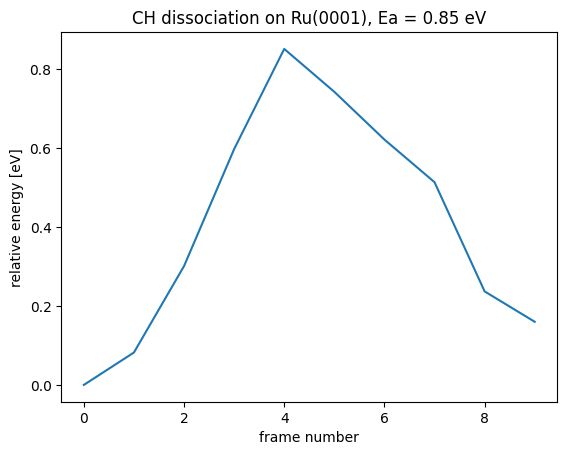

In [15]:
# Plot the reaction coordinate

es = [e - es[0] for e in es]
plt.plot(es)
plt.xlabel("frame number")
plt.ylabel("relative energy [eV]")
plt.title(f"CH dissociation on Ru(0001), Ea = {max(es):1.2f} eV")
plt.savefig("CH_dissoc_on_Ru_0001.png")

To generalize an interactive visualization, use `ase gui` from the command line or the X3D package

In [ ]:
# Make an interative html file of the optimized neb trajectory
x3d = X3D(optimized_neb)
x3d.write("optimized_neb_ch_disoc_on_Ru0001.html")